In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

pd.set_option("mode.copy_on_write", True)

In [3]:
path_processed = "processed/tuntidata_processed.csv"

df = pd.read_csv(path_processed, header=0)

df.head(10)

,date,weekday,hour,datetime,quantity
0,2023-01-02,0,10,2023-01-02 10:00:00,18.0
1,2023-01-02,0,11,2023-01-02 11:00:00,83.0
2,2023-01-02,0,12,2023-01-02 12:00:00,79.0
3,2023-01-02,0,13,2023-01-02 13:00:00,90.0
4,2023-01-02,0,14,2023-01-02 14:00:00,1.0
5,2023-01-03,1,10,2023-01-03 10:00:00,26.0
6,2023-01-03,1,11,2023-01-03 11:00:00,88.0
7,2023-01-03,1,12,2023-01-03 12:00:00,94.0
8,2023-01-03,1,13,2023-01-03 13:00:00,108.0
9,2023-01-03,1,14,2023-01-03 14:00:00,10.0


<Axes: xlabel='datetime'>

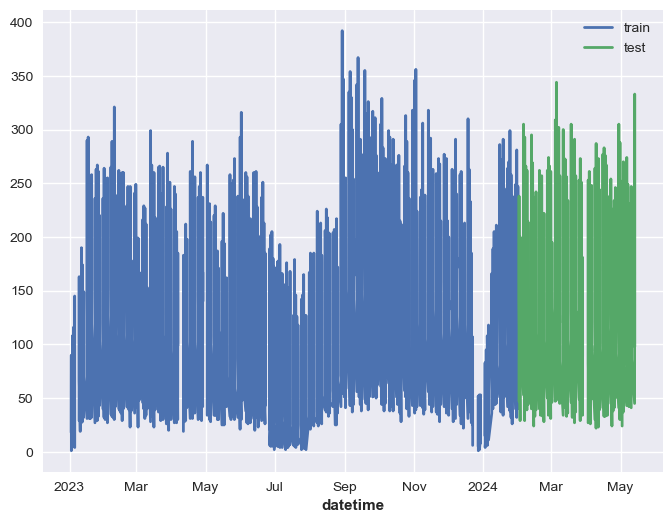

In [4]:
freq = pd.offsets.CustomBusinessHour(start="10:00", end="15:00", weekmask="Mon Tue Wed Thu Fri")
ts = TimeSeries.from_dataframe(df=df, time_col='datetime', value_cols='quantity', freq=freq, fillna_value=None)

cutoff_date = pd.to_datetime('2024-02-01')
train, test = ts.split_before(cutoff_date)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')

# Extract datetime-related covariates

In [5]:
ts_dayofweek_cyclic = datetime_attribute_timeseries(
    ts,
    attribute='dayofweek',
    cyclic=True
)

cov_dayofweek_cyclic = ts_dayofweek_cyclic.data_array().to_numpy().squeeze(-1)

In [6]:
ts_hour_cyclic = datetime_attribute_timeseries(ts, attribute='hour', cyclic=True)

cov_hour_cyclic = ts_hour_cyclic.data_array().to_numpy().squeeze(-1)

In [7]:
ts_new = ts\
    .add_datetime_attribute(attribute='dayofweek', cyclic=True)\
    .add_datetime_attribute(attribute='hour', cyclic=True)

In [8]:
df_new = ts_new.pd_dataframe().reset_index()

df_new.head(20)

component,datetime,quantity,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
0,2023-01-02 10:00:00,18.0,0.000000,1.000000,5.000000e-01,-0.866025
1,2023-01-02 11:00:00,83.0,0.000000,1.000000,2.588190e-01,-0.965926
2,2023-01-02 12:00:00,79.0,0.000000,1.000000,1.224647e-16,-1.000000
3,2023-01-02 13:00:00,90.0,0.000000,1.000000,-2.588190e-01,-0.965926
4,2023-01-02 14:00:00,1.0,0.000000,1.000000,-5.000000e-01,-0.866025
5,2023-01-03 10:00:00,26.0,0.781831,0.623490,5.000000e-01,-0.866025
6,2023-01-03 11:00:00,88.0,0.781831,0.623490,2.588190e-01,-0.965926
7,2023-01-03 12:00:00,94.0,0.781831,0.623490,1.224647e-16,-1.000000
8,2023-01-03 13:00:00,108.0,0.781831,0.623490,-2.588190e-01,-0.965926
9,2023-01-03 14:00:00,10.0,0.781831,0.623490,-5.000000e-01,-0.866025


In [9]:
for lag in [5, 10, 15, 20, 25]:
    newcol_name = f"lag{lag}"
    df_new.loc[:, newcol_name] = df_new['quantity'].shift(lag)

df_new.head(20)

component,datetime,quantity,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,lag5,lag10,lag15,lag20,lag25
0,2023-01-02 10:00:00,18.0,0.000000,1.000000,5.000000e-01,-0.866025,NaN,NaN,NaN,NaN,NaN
1,2023-01-02 11:00:00,83.0,0.000000,1.000000,2.588190e-01,-0.965926,NaN,NaN,NaN,NaN,NaN
2,2023-01-02 12:00:00,79.0,0.000000,1.000000,1.224647e-16,-1.000000,NaN,NaN,NaN,NaN,NaN
3,2023-01-02 13:00:00,90.0,0.000000,1.000000,-2.588190e-01,-0.965926,NaN,NaN,NaN,NaN,NaN
4,2023-01-02 14:00:00,1.0,0.000000,1.000000,-5.000000e-01,-0.866025,NaN,NaN,NaN,NaN,NaN
5,2023-01-03 10:00:00,26.0,0.781831,0.623490,5.000000e-01,-0.866025,18.0,NaN,NaN,NaN,NaN
6,2023-01-03 11:00:00,88.0,0.781831,0.623490,2.588190e-01,-0.965926,83.0,NaN,NaN,NaN,NaN
7,2023-01-03 12:00:00,94.0,0.781831,0.623490,1.224647e-16,-1.000000,79.0,NaN,NaN,NaN,NaN
8,2023-01-03 13:00:00,108.0,0.781831,0.623490,-2.588190e-01,-0.965926,90.0,NaN,NaN,NaN,NaN
9,2023-01-03 14:00:00,10.0,0.781831,0.623490,-5.000000e-01,-0.866025,1.0,NaN,NaN,NaN,NaN


In [10]:
df_new = df_new.dropna()

## Split train/test

In [11]:
cutoff_date = pd.to_datetime('2024-02-01')

train = df_new[df_new['datetime'] <= cutoff_date]
test = df_new[df_new['datetime'] > cutoff_date]

In [12]:
cols_exo = ['dayofweek_sin', 'dayofweek_cos', 'hour_sin', 'hour_cos', 'lag5', 'lag10', 'lag15', 'lag20', 'lag25']
col_end = 'quantity'

def get_Xy(split: pd.DataFrame):
    return split[cols_exo], split[col_end].to_numpy().reshape(-1, 1)

Xtrain, ytrain = get_Xy(train)
Xtest, ytest = get_Xy(test)

## Start training

In [13]:
def get_metrics(gt, pred) -> tuple:
    mse_score = metrics.mean_squared_error(gt, pred)
    rmse_score = np.sqrt(mse_score)
    mae_score = metrics.mean_absolute_error(gt, pred)

    print(f"MSE : {mse_score:.5f}")
    print(f"RMSE: {rmse_score:.5f}")
    print(f"MAE : {mae_score:.5f}")

    return mse_score, rmse_score, mae_score

In [14]:
model_linear = LinearRegression()

model_linear.fit(Xtrain, ytrain)

ytest_pred = model_linear.predict(Xtest)

get_metrics(ytest, ytest_pred)

MSE : 2358.42727
RMSE: 48.56364
MAE : 40.70732


(2358.427268369492, 48.56364142410958, 40.707316309654345)

In [15]:
model_linear = RandomForestRegressor()

model_linear.fit(Xtrain, ytrain.ravel())

ytest_pred = model_linear.predict(Xtest)

_ = get_metrics(ytest, ytest_pred)

MSE : 737.28093
RMSE: 27.15292
MAE : 20.10730


<Axes: xlabel='datetime'>

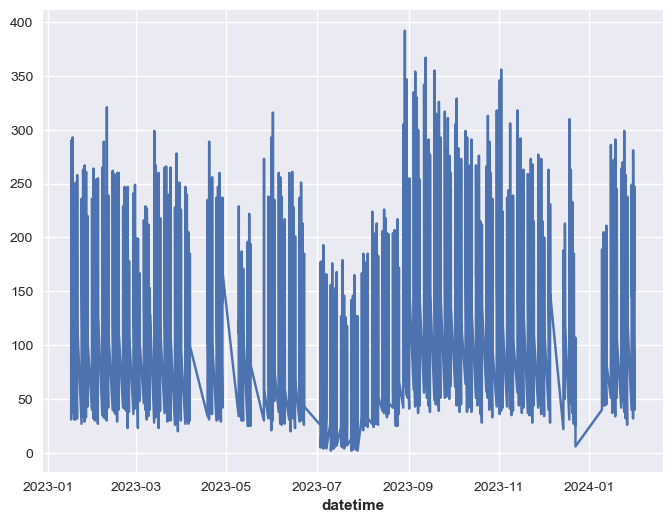

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.lineplot(x=train['datetime'], y=ytrain.squeeze(), ax=ax)